<a href="https://colab.research.google.com/github/AngelinaSmi/Digital-image-processing/blob/main/Lb6_DIP_Smirnova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа № 6 Смирновой А.Е. 24ВВИм1**

Задание: выделить апельсины на изображении методом сегментации изображений.

Загружем необходимые библиотеки, изображение, преобразуем в модель RGB и выведим его

In [29]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import math

In [30]:
image = cv.imread('lb5.jpg')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

**1 метод: Сегментация алгоритмом водораздела**

Алгоритм основан на представлении изображения как топографической поверхности, заполняемой водой. Тогда границы сегментов – это линии водораздела.

На такой поверхности существует 3 типа точек:

1 Локальные минимумы.

2 Точки, в которых вода скатывается в единственный локальный минимум.

3 Точки, в которых вода может с равной вероятностью скатиться в несколько минимумов.

Точки, удовлетворяющие 2-му условию, называются водосборным бассейном.

Точки, которые удовлетворяют 3-му условию, называются линиями водораздела. Их необходимо найти.

Для упрощения изображения перед водоразделом разделим изображение на крупные сегменты методом K-means кластеризация

In [31]:
#сегментация методом K-means
Z = image_rgb.reshape((-1, 3))
Z = np.float32(Z)
K = 4  # число кластеров
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 1.0)
#группируем пиксели по цвету
_, labels, centers = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented = centers[labels.flatten()]
segmented_image = segmented.reshape(image_rgb.shape)
centers_rgb = np.uint8(centers.reshape(1, -1, 3))
centers_hsv = cv.cvtColor(centers_rgb, cv.COLOR_RGB2HSV)[0]
#показываем центры для контроля
print("HSV центры кластеров:")
for i, c in enumerate(centers_hsv):
    print(f"Кластер {i}: H={c[0]}, S={c[1]}, V={c[2]}")
#выбираем кластеры, где H — оранжевый, S достаточно высока, V не слишком светлое
orange_clusters = [
    i for i, c in enumerate(centers_hsv)
    if (5 <= c[0] <= 30) and (c[1] > 120) and (c[2] < 250)
]
#создаем маску по выбранным кластерам
mask_kmeans = np.isin(labels.flatten(), orange_clusters)
mask_kmeans = mask_kmeans.reshape((image_rgb.shape[0], image_rgb.shape[1]))
mask_kmeans = np.uint8(mask_kmeans) * 255
#морфологическая очистка
kernel = np.ones((7, 7), np.uint8)
mask_kmeans = cv.morphologyEx(mask_kmeans, cv.MORPH_CLOSE, kernel)
mask_kmeans = cv.morphologyEx(mask_kmeans, cv.MORPH_OPEN, kernel)

result_kmeans = cv.bitwise_and(image_rgb, image_rgb, mask=mask_kmeans)

#преобразуем результат K-means в оттенки серого
gray = cv.cvtColor(result_kmeans, cv.COLOR_RGB2GRAY)

HSV центры кластеров:
Кластер 0: H=10, S=35, V=22
Кластер 1: H=26, S=12, V=169
Кластер 2: H=30, S=39, V=52
Кластер 3: H=16, S=222, V=191


Применим алгоритм водораздела

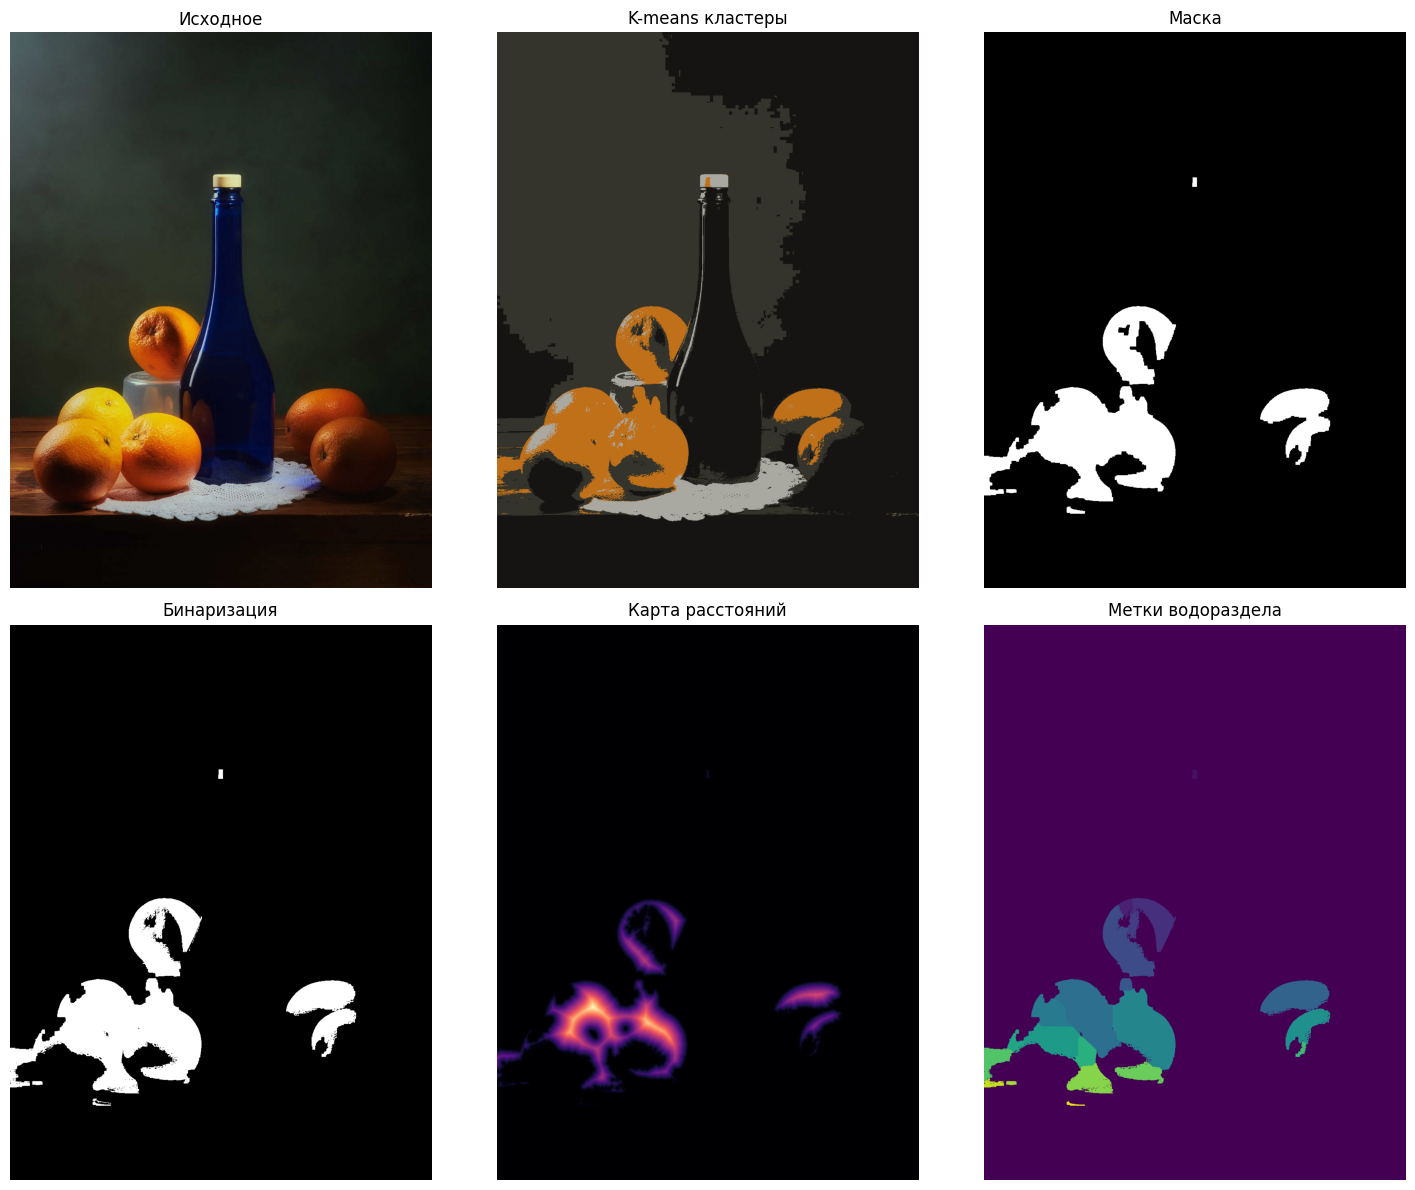

In [32]:
# Алгоритм водораздела (Watershed)
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, min_distance=20, labels=binary_image)
peaks_mask = np.zeros_like(distance_map, dtype=bool)
ind = np.array([i for i in local_max])
peaks_mask[ind[:, 0], ind[:, 1]] = True
# Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(peaks_mask, structure=np.ones((3, 3)))[0]
labels_ws = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Исходное")
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(segmented_image)
plt.title("K-means кластеры")
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(mask_kmeans, cmap="gray")
plt.title("Маска")
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(binary_image, cmap="gray")
plt.title("Бинаризация")
plt.axis("off")
plt.subplot(2, 3, 5)
plt.imshow(distance_map, cmap="magma")
plt.title("Карта расстояний")
plt.axis("off")
plt.subplot(2, 3, 6)
plt.imshow(np.uint8(labels_ws))
plt.title("Метки водораздела")
plt.axis("off")
plt.tight_layout()
plt.show()


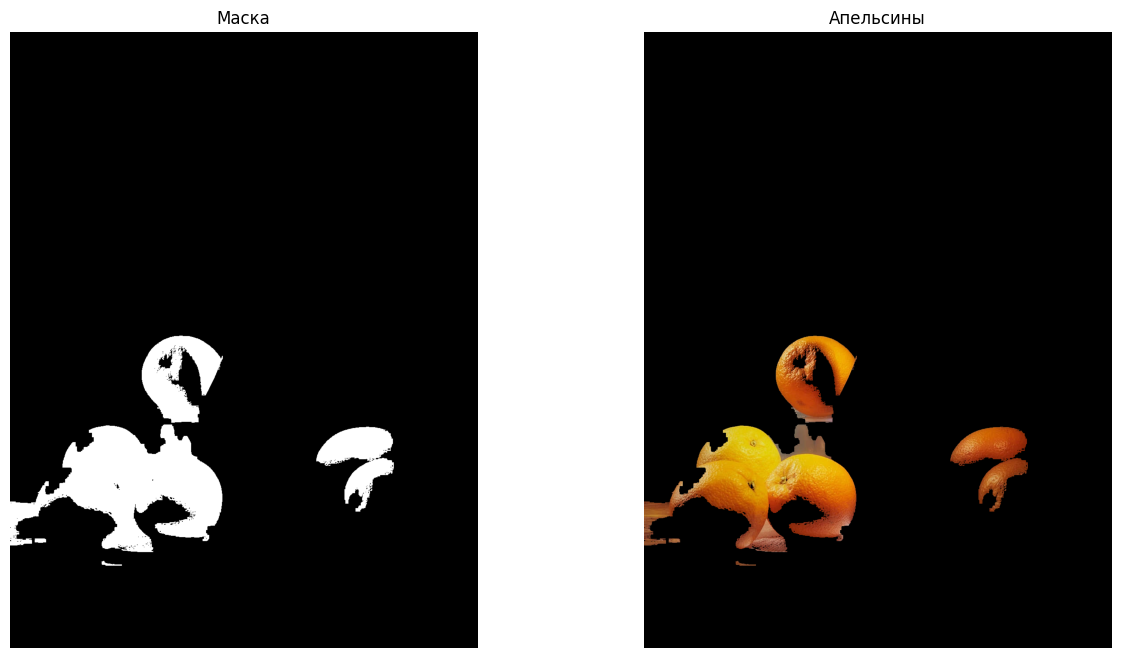

In [33]:
# Выделяем только области апельсинов по результату водораздела
mask_final = np.zeros(image.shape[:2], dtype="uint8")
for label in np.unique(labels_ws):
    if label < 2:  # пропускаем фон и шум
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels_ws == label] = 255
    mask_final = cv.bitwise_or(mask_final, mask)

# накладываем финальную маску
result_final = cv.bitwise_and(image_rgb, image_rgb, mask=mask_final)

# Финальный результат
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(mask_final, cmap="gray")
plt.title("Маска")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_final)
plt.title("Апельсины")
plt.axis("off")
plt.show()

**метод 2: K-средних**

[[ 14 213 180]
 [ 62  56  48]
 [ 37 195  34]]


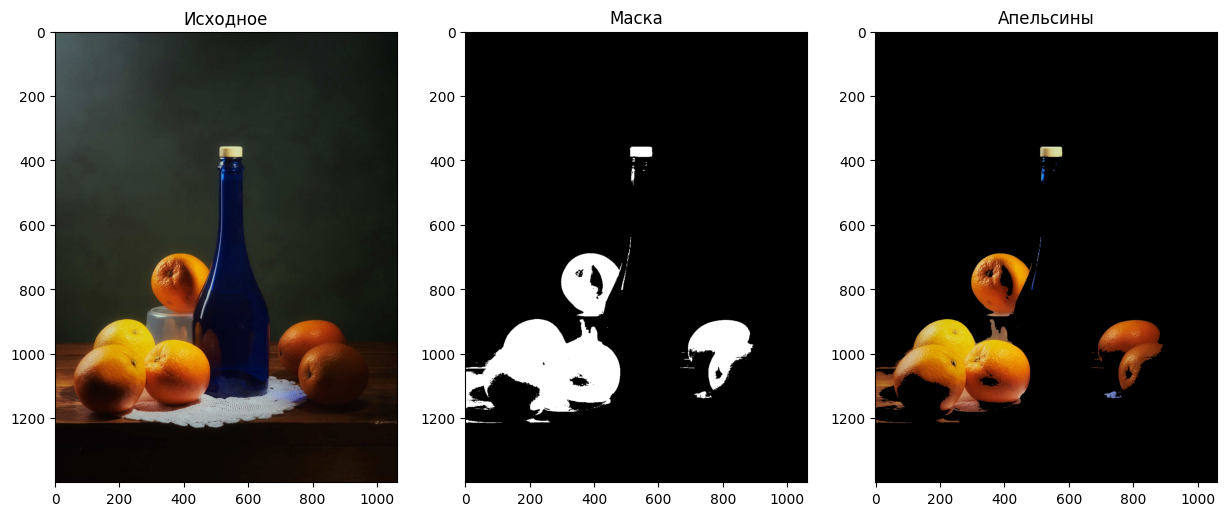

In [43]:
image = cv.imread('lb5.jpg')
# Преобразуем изображение в пространство HSV (лучше для выделения цвета)
hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = hsv.reshape(-1, 3)
# Задаем число кластеров для сегментации
K = 3
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_

# Выводим центры кластеров для анализа (HSV)
print(np.uint8(cluster_centers))
# Находим кластер, соответствующий оранжевому цвету
# Обычно для оранжевого H около 15-30 (в градусах), в OpenCV H в интервале 0-179
# Будем искать кластер с Hue в этом диапазоне
orange_cluster = None
for i, center in enumerate(cluster_centers):
    hue = center[0]
    sat = center[1]
    val = center[2]
    if 10 <= hue <= 35 and sat > 100 and val > 50:
        orange_cluster = i
        break

if orange_cluster is None:
    print("Оранжевый кластер не найден")
else:
    # Создаем маску только для оранжевого кластера
    mask = (labels == orange_cluster).reshape(image.shape[:2]).astype(np.uint8) * 255

    # Применяем маску к исходному изображению
    result = cv.bitwise_and(image, image, mask=mask)

    # Отображаем результаты
    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.title('Исходное')
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Маска')
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Апельсины')
    plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    plt.show()

**3 метод: Сдвиг среднего**

Метод основан на непараметрической оценке плотности распределения признаков пикселей (яркость, градиент и т.п.). Для непараметрической оценки применяются ядерные функции. Алгоритм сдвига среднего ищет локальные максимуму плотности распределения в n-мерном пространстве признаков.

In [35]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(image_rgb, 5)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1, 3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=0.08, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labels = ms.labels_
# получим количество сегментов
segments = np.unique(labels)
print('Количество сегментов:', len(segments))

Количество сегментов: 19


Количество сегментов: 19
Найдены оранжевые сегменты: [1, 4, 5, 7, 8, 9, 10]


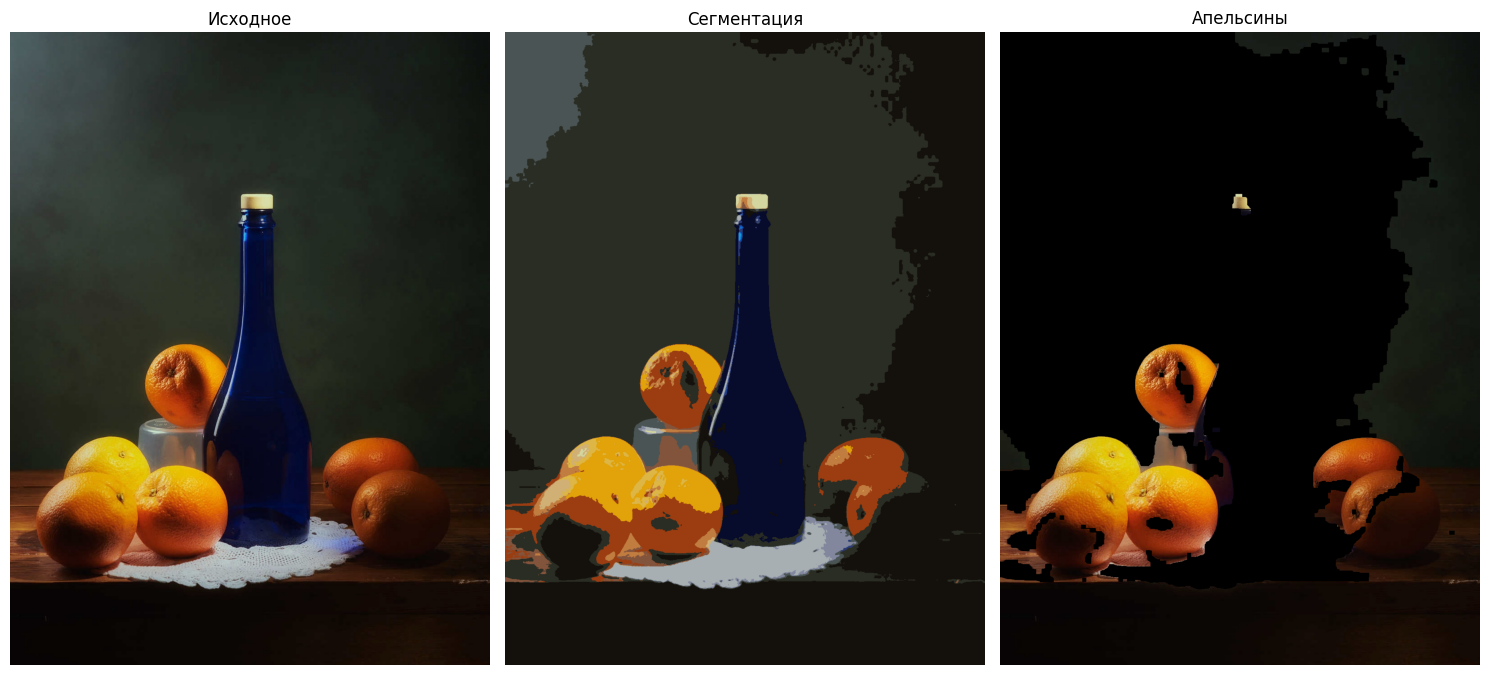

In [36]:
# Средние цвета сегментов
segments = np.unique(labels)
print("Количество сегментов:", len(segments))
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labels):
    total[label] += flat_image[i]
    count[label] += 1
avg = np.uint8(total / count)

# Восстанавливаем сегментированное изображение
mean_shift_image = avg[labels].reshape(image_rgb.shape)
# Определяем оранжевые сегменты автоматически
avg_hsv = cv.cvtColor(np.uint8(avg.reshape(1, -1, 3)), cv.COLOR_RGB2HSV)[0]
orange_segments = []
for i, (h, s, v) in enumerate(avg_hsv):
    if 5 <= h <= 30 and s > 100 and v < 250:
        orange_segments.append(i)
print("Найдены оранжевые сегменты:", orange_segments)

# Формируем маску только для оранжевых сегментов
mask = np.isin(labels, orange_segments).astype(np.uint8)
mask = mask.reshape(image_rgb.shape[:2]) * 255
# Морфологическая очистка
kernel = np.ones((9, 9), np.uint8)
mask_clean = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
mask_clean = cv.morphologyEx(mask_clean, cv.MORPH_OPEN, kernel)
# Оставляем только апельсины
result = cv.bitwise_and(image_rgb, image_rgb, mask=mask_clean)


plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Исходное")
plt.imshow(image_rgb)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Сегментация")
plt.imshow(mean_shift_image)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Апельсины")
plt.imshow(result)
plt.axis("off")
plt.tight_layout()
plt.show()